#  SWB211: Identifying Candidates for Great Jobs KC @ Kansas City Scholars
 Prepared by SWB Team: Tyler Will, Stefanie Senger, Fracisco Avalos Jr., Won Fy Lee & Statistical Consultant, Olusegun Ewemooje

## Executive Summary

*  #### Purpose:
    *  Identify eligible candidates in the Kansas City metropolitan area for the Great Jobs KC program @ Kansas City Scholars, a non-profit academic support program. 
    *  The U.S. census and American community survey data used was found as close as possible to match the eligibility requirements of KCS applicants.

*  #### Summary of results: 

    *  We estimate that there are 611,675 eligible candidates in the 6 countries comprising the greater Kansas City metro. 
    *  The eligible population make up 31 percent of total population in the 6 counties (=611,675/1,964,222).
    
* #### Deliverables:
    *  We provide block-level maps of following features ([Link to Maps](https://swb211.netlify.app/)):
        *  Raw number of eligible candidates.
        *  Population density (number of eligible candidates per sq mile).
        *  Hotspot geospatial analysis that shows statistically significant high/low density areas.
        *  Estimated location of eligible population (10\% sample, appox.61,000 points ).
        
    *  [Block-level final output data in excelsheet](https://drive.google.com/file/d/1ZKh9Ub0oWdtFMsucgcXdWBRb2oqMJpU4/view?usp=sharing) 
         
    *  [Zipcode-level density of eligible population in excelsheet](https://docs.google.com/spreadsheets/d/12_JI2aAmCzH1VGi3ocEYxKKIdCQsDy4vBT2fB3BRzMU/edit#gid=0)
    * Additional descriptives:
        * Block-level choropleth map by key features.
        * Zipcode-level density map
        * County-level density map
        * Spatial Autocorrelation map
        
* #### Conclusion and Implication:
     * Marketing resources should be allocated in high-density areas (colored in red areas) identified on the [Map](https://swb211.netlify.app/target_v5)
         * The top 5 high-density eligible popluation zipcode areas are 64124, 64123, 64106, 64127, 64128 in Jackson County.
         * There appears to be some spatial autocorrelation for our target areas (hot spot locations) at the local level. However, there isn't a significant spatial autocorrelation that points to one or more regions of KC counties as hot spots. This may suggest strategic target zones to direct marketing resources based on spatial analysis.

### Introduction
Kansas City Scholars is a rapidly-expanding non-profit offering scholarship and academic support programs in its home metro.  As part of this broader expansion, the KCS seeks to identify areas where eligible candidates for their Great Jobs KC program are located.  

The goal of this project is to estimate the spatial distribution of candidates eligible for Great Jobs KC using as fine-grained data as possible. 

An individual is eligible for Great Jobs KC if s/he meets all of the following criteria:

 1. 18 years or older 
 2. Live in one of the six eligible counties (KS: Wyandotte, Johnson; Missouri: Cass, Clay, Jackson, Platte) 
 3. Low or modest income evidenced by current earnings of less than $45,000 annually
 4. Has not previously earned a bachelor’s degree
 5. Has not previously been awarded a KC Scholarship (Traditional or Adult Learner)
 6. Not a current KC Scholars college scholarship awardee
 7. Lawfully present in the United States or DACA eligible and DACA applied/approved

### Data 

The lowest-level geography data available from Census is block-level. A census block in the six counties has an average population of 21. In terms of relative size, a census tract contains 70 blocks and a census block-group contains an average of 23 blocks. Despite the small size of the block, only total population count information is available at the block-level. 


The lowest-level geography data available for #1, #3 and #4 is block-group from 2021 American Community Survey. In addition, only marginal information of \%age, \%income and \%education is available, while the information we need to define eligible population is joint density of \%age X \%income X \%education. 

Eligiblity criteria (5) and (6) were not included in the estimation, given an assumption that the number of past and current KC scholars is small relative to the total eligible population.  In addition, given the difficulties and nuances associated with eligibility criteria (7), we assumed this criteria was satisfied.  

A number of other datasets, including JobsEQ data and Economic Equity Value Atlas data, were considered for analysis but ultimately excluded; we found that using exclusively census data 

### Method

As stated above, only marginal information is available for each variable.  To derive the joint density, we assume variable independence (Assumption 1):

 \begin{align}
 Pr(I,E,A|bg)=Pr(I|bg)Pr(E|bg)Pr(A|bg)
  \label{eq1}\tag{1} \\
 \end{align}
 
where  Block=b, Block-group=bg, Income=I, Education=E, Age=A.

 In order to leverage both block and block-group level data available, we consolidate the data from two different levels of geography by assuming that populations in blocks within a same block-group share same %age, %income and %education defined at the block-group, while respecting the total population counts defined at the block-level (Assumption 2):
 
 \begin{align}
         N(I, E, A|b,bg) = Pr(I,E,A|bg)*N(b|bg)
  \label{eq2}\tag{2} \\
 \end{align}
 
#### Adjustment to Assumption 1:

We found high correlation between \%income and \% education (~= 0.9). To adjust high correlation between \% low income and \% education lt BA, we run a simple bivariate linear regression with independent variable (X) defined as \% annual income less than 45,000 dollars and dependent variable (Y) set as \% population with less than bachelors degree. We use \% education instead of \%income as dependent variable, simply because the \% low education is much higher than the \% income less than 45k (63\% vs 54\%). The predicted value out of this regression gives us an adjusted share for Pr(I|bg) that account for the correlation between the two variable and it is strictly larger than the original Pr(I|bg).


\begin{align}
\underbrace{\hat{Y}}_{\%education} =\underbrace{\alpha}_{intercept} + \underbrace{\beta}_{slope} * \underbrace{X}_{\%income} +\underbrace{\epsilon}_{error}  \label{eq3}\tag{3} \\
 \end{align}
 

See Sections 9 - 13.



 



In [4]:
%%html
<iframe src="https://swb211.netlify.app/target_v2" width="1200" height="1000"></iframe>

In [2]:
%%html
<iframe src="https://swb211.netlify.app/target_v3" width="1200" height="1000"></iframe>

In [47]:
%%html
<iframe src="https://swb211.netlify.app/target_v4" width="1200" height="1000"></iframe>

In [263]:
%%html
<iframe src="https://swb211.netlify.app/target_v5" width="1200" height="1000"></iframe>

In [51]:
%%html


   <table style="font-size:0.9em">
    	<thead><tr>
            <th> </th>
            <th>N</th>            
            <th>Mean</th> 

        </tr></thead>
        <tbody><tr>
            <td>s_bg_age_gt18</td>
            <td>37700</td>            
            <td>0.75</td> 

        </tr>
        <tr>
            <td>s_pinc_lt_45k</td>
            <td>37700</td>
            <td>0.56</td> 

        </tr>
        <tr>
            <td>s_bg_educ_lt_bachelors</td>
            <td>37700</td>
            <td>0.63</td> 
           
        </tr>
        <tr>
            <td>s_joint_age_educ_inc</td>
            <td>37700</td>
            <td>0.33</td> 
            
        </tr>
               
    </tbody>
    </table>

,N,Mean
s_bg_age_gt18,37700,0.75
s_pinc_lt_45k,37700,0.56
s_bg_educ_lt_bachelors,37700,0.63
s_joint_age_educ_inc,37700,0.33


In [3]:
%%html
<table style="font-size:0.8em">
    	<thead><tr>
            <th>County</th>
            <th>N CensusTract</th>            
            <th>N BlockGroup</th>
            <th>N Block</th>
            <th>Blocks per BG</th> 

        </tr></thead>
        <tbody><tr>
            <td>Cass</td>
            <td>24</td>            
            <td>83</td>
            <td>3571</td>
            <td>43</td> 

        </tr>
        <tr>
            <td>Clay</td>
            <td>55</td>
            <td>192</td>
            <td>5222</td>
            <td>27</td> 

        </tr>
        <tr>
            <td>Jackson</td>
            <td>227</td>
            <td>640</td>
            <td>14842</td>
             <td>23</td> 
           
        </tr>
        <tr>
            <td>Johnson</td>
            <td>154</td>
            <td>462</td>
            <td>8235</td>
            <td>18</td> 
            
        </tr>
        <tr>
            <td>Platte</td>
            <td>26</td>
            <td>80</td>
            <td>2475</td>
            <td>31</td> 
            
        </tr>
        <tr>
            <td>Wyandotte</td>
            <td>64</td>
            <td>165</td>
            <td>3355</td>
            <td>20</td> 
            
        </tr>    
        <tr>
            <td>Total</td>
            <td>550</td>
            <td>1622</td>
           <td>37700</td>
            <td>23</td> 
            
        </tr>              
    </tbody>
</table>

County,N CensusTract,N BlockGroup,N Block,Blocks per BG
Cass,24,83,3571,43
Clay,55,192,5222,27
Jackson,227,640,14842,23
Johnson,154,462,8235,18
Platte,26,80,2475,31
Wyandotte,64,165,3355,20
Total,550,1622,37700,23


# Code
Python code replicating our analysis is given below.  
## Joint Density Calculation
### Data downloaded from https://www.nhgis.org/

- 2020 Census, Block level
  - Total Population Counts
- 2021 American Community Survey: 5-Year Data, Block-group level
  - Counts by age
  - Counts by education 
  - Counts by earnings




### 1. Imports

In [1]:
import pandas as pd 
import os

### Path Management
using [`os.path.join`](https://docs.python.org/3/library/os.path.html), to fit the paths for Linux/MacOS and Windows syntax, which is more robust:
* Linux/MacOS syntax (e.g. `../folder_name`) 
* and Windows syntax (e.g. `..\\folder_name`) 

In [2]:
wd='/Users/wonfylee/Library/CloudStorage/GoogleDrive-leex5089@umn.edu/My Drive/0.SWB/SWB211'

csv_path_population_block = os.path.join(wd, 'census_data', 'nhgis0202_csv', 'nhgis0202_ds248_2020_block.csv')
csv_path_education_income = os.path.join(wd, 'census_data', 'nhgis0197_csv', 'nhgis0197_ds254_20215_blck_grp.csv')
csv_path_personal_income = os.path.join(wd, 'census_data', 'nhgis0205_csv', 'nhgis0205_ds254_20215_blck_grp.csv')

csv_path_age = os.path.join(wd, 'census_data', 'nhgis0203_csv', 'nhgis0203_ds254_20215_blck_grp.csv')

dta_path_6_counties = os.path.join(wd, 'intermediate_data', 'b_KC_6counties.dta')
dta_path_county_crosswalk = os.path.join(wd, 'intermediate_data', 'b_bg_county_crosswalk.dta')

### 2. DataFrame of population count per house block
#### [Download block-level Data](https://drive.google.com/file/d/1PpBdZLxjuU8gYFRaH1YH8Mo_jQyvucTD/view?usp=share_link)
#### [Download codebook](https://drive.google.com/file/d/1Q07GfUr7E_S7Of81rsdNRAorfGjtKotN/view?usp=share_link)


In [3]:
block_raw = pd.read_csv(csv_path_population_block, low_memory=False)
block_raw.columns = block_raw.columns.str.lower()
 
block_data = block_raw[['gisjoin', 'state','county','u7b001']]
block_data = block_data.rename(columns={'gisjoin': 'b_gisjoin'})                
block_data = block_data.rename(columns={'u7b001': 'b_population'}) # b_target_pop: Block level estimate of total population.

block_data            
block_data['b_population'].mean()

21.33652070461633

### 3. DataFrame of household income and individual's educational status accumulated per block group
A block group is a collection of several house blocks; approximatly 30-50 blocks form a block group.
#### [Download block group-level Data](https://drive.google.com/file/d/1Pk3rLOX4K3efD69GoOQ5lFa2apiqGJPM/view?usp=share_link  )
#### [Download codebook](https://drive.google.com/file/d/1PfbiBFwF5PAS1Kq6Fdy8_6klsqOxRE5b/view?usp=share_link)

Note: We use personal earnings data instead of household income in the analysis.


In [4]:
blockgroup_raw = pd.read_csv(csv_path_education_income)
blockgroup_raw.columns = blockgroup_raw.columns.str.lower()
col_list=blockgroup_raw[['aop8e002', 'aop8e003', 'aop8e004', 'aop8e005', 'aop8e006', 'aop8e007', 'aop8e008' ,'aop8e009', 'aop8e010', 'aop8e011', 'aop8e012', 'aop8e013', 'aop8e014', 'aop8e015', 'aop8e016', 'aop8e017', 'aop8e018', 'aop8e019', 'aop8e020', 'aop8e021']]
blockgroup_raw['bg_educ_lt_bachelors']=col_list.sum(axis=1) # summing population count below bachelor's degree
col_list=blockgroup_raw[['aoqhe002', 'aoqhe003', 'aoqhe004', 'aoqhe005', 'aoqhe006', 'aoqhe007', 'aoqhe008', 'aoqhe009']]
blockgroup_raw['bg_inc_lt_45000']=col_list.sum(axis=1) # summing housdhold inclome below 45 k

blockgroup_raw['s_bg_educ_lt_bachelors']=blockgroup_raw['bg_educ_lt_bachelors']/blockgroup_raw['aop8e001'] # percentage of non-BA's over whole population (creates Nan values where the population per block group is 0)
blockgroup_raw['s_bg_inc_lt_45000']=blockgroup_raw['bg_inc_lt_45000']/blockgroup_raw['aoqhe001'] # percentage of low earning households over all housholds (creates Nan values where the population per block group is 0)
blockgroup_raw = blockgroup_raw.rename(columns={'gisjoin': 'bg_gisjoin'})                
bg_educ_inc=blockgroup_raw[['bg_gisjoin', 'bg_educ_lt_bachelors','bg_inc_lt_45000','s_bg_educ_lt_bachelors','s_bg_inc_lt_45000']]

bg_educ_inc

,bg_gisjoin,bg_educ_lt_bachelors,bg_inc_lt_45000,s_bg_educ_lt_bachelors,s_bg_inc_lt_45000
0,G20000109526001,1146,195,0.861007,0.281792
1,G20000109527001,548,210,0.734584,0.466667
2,G20000109527002,527,110,0.780741,0.303867
3,G20000109528001,521,240,0.785822,0.551724
4,G20000109528002,650,252,0.672878,0.464945
...,...,...,...,...,...
7487,G29051001277001,661,211,0.937589,0.703333
7488,G29051001277002,654,289,1.000000,0.865269
7489,G29051001277003,176,79,0.752137,0.576642
7490,G29051001278001,959,982,0.762928,0.891916


### 4. DataFrame of population's age accumulated per block group
#### [Download block group-level Data](https://drive.google.com/file/d/1Q5OGL-dRmYbJO7Q8WGjSahMS3s1QBnAI/view?usp=share_link )
#### [Download codebook](https://drive.google.com/file/d/1Q7LJjJytZHH-n66zZ5RvwTxnMIus9lLX/view?usp=share_link)

A block group is a collection of several house blocks; approximatly 30-50 blocks form a block group.

In [5]:
blockgroup_raw = pd.read_csv(csv_path_age)
blockgroup_raw.columns = blockgroup_raw.columns.str.lower()
blockgroup_raw.describe()
print(blockgroup_raw.info())
blockgroup_raw.dtypes 
col_list=blockgroup_raw[['aonte007', 'aonte008', 'aonte009', 'aonte010', 'aonte011', 'aonte012', 'aonte013', 'aonte014', 'aonte015', 'aonte016' ,'aonte017', 'aonte018', 'aonte019' ,'aonte020', 'aonte021', 'aonte022', 'aonte023' ,'aonte024' ,'aonte025' ,'aonte031' ,'aonte032', 'aonte033', 'aonte034' ,'aonte035', 'aonte036', 'aonte037', 'aonte038', 'aonte039', 'aonte040', 'aonte041', 'aonte042', 'aonte043', 'aonte044', 'aonte045', 'aonte046', 'aonte047', 'aonte048', 'aonte049']]
blockgroup_raw['bg_age_gt18']=col_list.sum(axis=1) # summing population count 18 years and older
blockgroup_raw['s_bg_age_gt18']=blockgroup_raw['bg_age_gt18']/blockgroup_raw['aonte001'] # percentage of population 18 years and older over whole population (creates Nan values where the population per block group is 0)
blockgroup_raw = blockgroup_raw.rename(columns={'gisjoin': 'bg_gisjoin'})
bg_age=blockgroup_raw[['bg_gisjoin', 'bg_age_gt18','s_bg_age_gt18']]

bg_age

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7492 entries, 0 to 7491
Columns: 1001 entries, gisjoin to aoslm036
dtypes: float64(76), int64(917), object(8)
memory usage: 57.2+ MB
None


,bg_gisjoin,bg_age_gt18,s_bg_age_gt18
0,G20000109526001,1415,0.769859
1,G20000109527001,845,0.795669
2,G20000109527002,726,0.823129
3,G20000109528001,841,0.819688
4,G20000109528002,1221,0.822222
...,...,...,...
7487,G29051001277001,747,0.772492
7488,G29051001277002,784,1.000000
7489,G29051001277003,318,0.736111
7490,G29051001278001,1598,0.820329


### 5. DataFrame of population's personal income (earnings) per block group
#### [Download block group-level Data](https://drive.google.com/file/d/1v8Fl1LpxaeQ13p56kd8M9Byug0cOKqZi/view?usp=share_link)
#### [Download codebook](https://drive.google.com/file/d/1v8YW6t1JpYowCY-O74lx4n1FbRZbboXe/view?usp=share_link)
Table: B20001. Sex by Earnings in the Past 12 Months (in 2021 Inflation-Adjusted Dollars) for the Population 16 Years and Over with Earnings in the Past 12 Months

Universe: Population 16 years and over with earnings

#### Earnings
As noted above, in Census Bureau terminology, earnings are a subset of income. Specifically, earnings are wages or salary from a job, or income from being self-employed. Other kinds of income, not included in earnings, include social security payments, interest and dividends, income from property rental, pensions, public assistance, and child support.
 

In [6]:
blockgroup_raw = pd.read_csv(csv_path_personal_income)
blockgroup_raw.columns = blockgroup_raw.columns.str.lower()
blockgroup_raw.describe()
print(blockgroup_raw.info())
blockgroup_raw.dtypes 
col_list=blockgroup_raw[['aor6e003', 'aor6e004', 'aor6e005', 'aor6e006', 'aor6e007', 'aor6e008', 'aor6e009', 'aor6e010', 'aor6e011', 'aor6e012', 'aor6e013', 'aor6e014', 'aor6e015', 'aor6e016', 'aor6e024' ,'aor6e025', 'aor6e026', 'aor6e027', 'aor6e028', 'aor6e029', 'aor6e030', 'aor6e031', 'aor6e032', 'aor6e033', 'aor6e034', 'aor6e035', 'aor6e036', 'aor6e037']]
blockgroup_raw['bg_pinc_lt_45k']=col_list.sum(axis=1) # summing population count 18 years and older
blockgroup_raw['s_bg_pinc_lt_45k']=blockgroup_raw['bg_pinc_lt_45k']/blockgroup_raw['aor6e001'] # percentage of population 18 years and older over whole population (creates Nan values where the population per block group is 0)
blockgroup_raw = blockgroup_raw.rename(columns={'gisjoin': 'bg_gisjoin'})
bg_personal_income=blockgroup_raw[['bg_gisjoin', 'bg_pinc_lt_45k','s_bg_pinc_lt_45k']]

bg_personal_income

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7492 entries, 0 to 7491
Columns: 129 entries, gisjoin to aor6m043
dtypes: float64(30), int64(91), object(8)
memory usage: 7.4+ MB
None


,bg_gisjoin,bg_pinc_lt_45k,s_bg_pinc_lt_45k
0,G20000109526001,523,0.561159
1,G20000109527001,444,0.805808
2,G20000109527002,324,0.642857
3,G20000109528001,434,0.811215
4,G20000109528002,539,0.707349
...,...,...,...
7487,G29051001277001,232,0.760656
7488,G29051001277002,251,0.886926
7489,G29051001277003,165,0.868421
7490,G29051001278001,734,0.890777


### 6. prepare cross-walk data 

In [7]:
##b_KC_6counties
b_KC_6counties = pd.read_stata(dta_path_6_counties)
b_KC_6counties.columns = b_KC_6counties.columns.str.lower()

##JOIN
b_bg_county_crosswalk = pd.read_stata(dta_path_county_crosswalk)
b_bg_county_crosswalk.columns = b_bg_county_crosswalk.columns.str.lower()
b_bg_county_crosswalk = b_bg_county_crosswalk[['b_gisjoin', 'bg_gisjoin']] # cutting down on unnecessary columns

b_KC_6counties
b_bg_county_crosswalk


,b_gisjoin,bg_gisjoin
0,G20009100500001000,G20009100500001
1,G20009100500001001,G20009100500001
2,G20009100500001002,G20009100500001
3,G20009100500001003,G20009100500001
4,G20009100500001004,G20009100500001
...,...,...
37696,G29016509800001121,G29016509800001
37697,G29016509800001122,G29016509800001
37698,G29016509800001123,G29016509800001
37699,G29016509800001124,G29016509800001


### 7. Merge block and block-group data

In [8]:
#merge B and BG level data, calculate target_density 
merge1=pd.merge(block_data, b_KC_6counties,on=['b_gisjoin' ])  # merge to restrict area to 6 counties in KC (426161 to 37701)
merge2=pd.merge(merge1, b_bg_county_crosswalk,on=['b_gisjoin' ])  # block block-group county crosswalk file
merge3=pd.merge(merge2, bg_age,on=['bg_gisjoin' ])  # add bg-level age
merge4=pd.merge(merge3, bg_educ_inc,on=['bg_gisjoin' ])  # add bg-level bg_educ_inc
merge5=pd.merge(merge4, bg_personal_income,on=['bg_gisjoin' ])  # add bg-level bg_educ_inc



# merge4.isna().sum().sort_values(ascending=False) # checking for Nan values
merge5 = merge5.fillna(0) # replacing Nan values with 0 
                          # (admissible, because those came into being by devision by 0 where the population count per block group was 0)
                          # (the percentage of target populaton in block groups without any population should be 0, presupposedly the data is correct)

        
        
merge5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37701 entries, 0 to 37700
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   b_gisjoin               37701 non-null  object 
 1   state                   37701 non-null  object 
 2   county                  37701 non-null  object 
 3   b_population            37701 non-null  int64  
 4   fid                     37701 non-null  int32  
 5   shape_area              37701 non-null  float32
 6   bg_gisjoin              37701 non-null  object 
 7   bg_age_gt18             37701 non-null  int64  
 8   s_bg_age_gt18           37701 non-null  float64
 9   bg_educ_lt_bachelors    37701 non-null  int64  
 10  bg_inc_lt_45000         37701 non-null  int64  
 11  s_bg_educ_lt_bachelors  37701 non-null  float64
 12  s_bg_inc_lt_45000       37701 non-null  float64
 13  bg_pinc_lt_45k          37701 non-null  int64  
 14  s_bg_pinc_lt_45k        37701 non-null

### 8. Calculate joint density of target population
In this case, we assume indepencence between the variables income, age and educational status, thus getting the joint probability P(I,E,A|bg)=P(I|bg)P(E|bg)Pr(A|bg). 

Response to Stefanie: for "target_pop_per_sq_mile" just wanted to change from per sq meter to per sq mile, so just needed a bracket in the denominator (merge5['shape_area'] / whole_area_6_counties)!

In [9]:
whole_population_6_counties=merge5['b_population'].sum()
whole_area_6_counties = 2589973.632302

# joint probability age*educ*income of target population
merge5['s_joint_age_educ_inc']=merge5['s_bg_age_gt18']*merge5['s_bg_educ_lt_bachelors']*merge5['s_bg_pinc_lt_45k']

# block-level estimate of target population
merge5['b_target_pop']=merge5['b_population']*merge5['s_joint_age_educ_inc']

# calculating density and distribution per sq miles
merge5['target_density']=(merge5['b_target_pop'] / whole_population_6_counties).fillna(0)
merge5['target_pop_per_sq_mile']=merge5['b_target_pop'] / (merge5['shape_area'] / whole_area_6_counties)



#### Working comment: Assuming independence of our variables (income, age and educational status) plus the very strict definition of household income instead of individual income makes us miss most of the target population.

##### Response: To address the concern about high correlation between income and educational status. I propose following adjustment to the density calculation.


### 9. check correlation between income and education

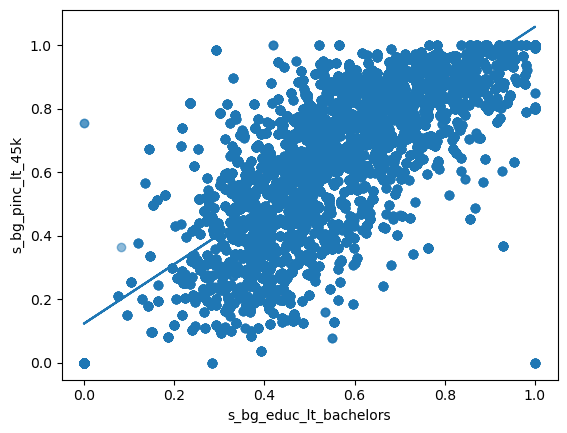

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(merge5['s_bg_pinc_lt_45k'], merge5['s_bg_educ_lt_bachelors'],  alpha=0.5)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(merge5['s_bg_pinc_lt_45k'],  merge5['s_bg_educ_lt_bachelors'], 1)

#add linear regression line to scatterplot 
x_pinc_lt_45k=merge5['s_bg_pinc_lt_45k']
plt.plot(merge5['s_bg_pinc_lt_45k'], m*x_pinc_lt_45k+b)
plt.xlabel("s_bg_educ_lt_bachelors")
plt.ylabel("s_bg_pinc_lt_45k")
plt.show()

### 10. check correlation between income and age

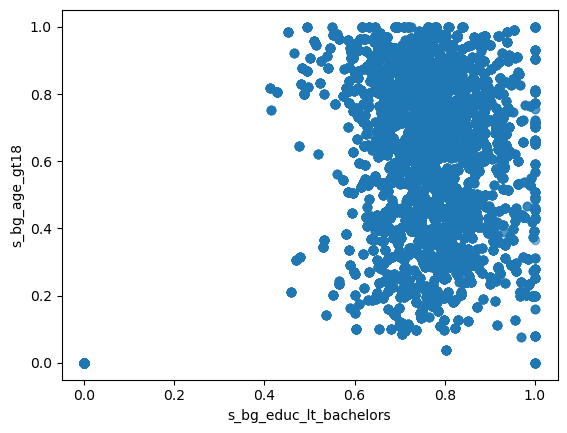

In [11]:
plt.scatter(merge5['s_bg_age_gt18'], merge5['s_bg_educ_lt_bachelors'],  alpha=0.5)
plt.xlabel("s_bg_educ_lt_bachelors")
plt.ylabel("s_bg_age_gt18")
plt.show()

#age correlation is low with other two vars.

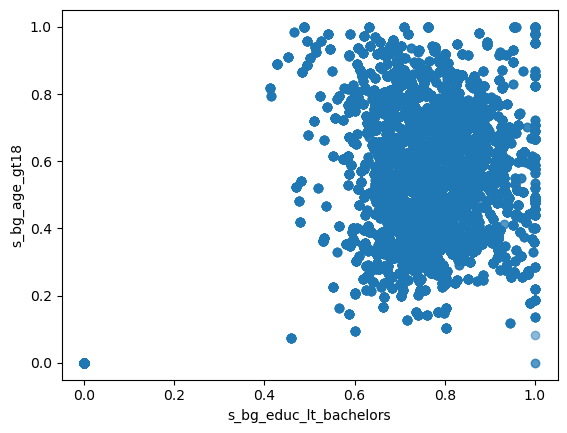

In [12]:
plt.scatter(merge5['s_bg_age_gt18'], merge5['s_bg_pinc_lt_45k'],  alpha=0.5)
plt.xlabel("s_bg_educ_lt_bachelors")
plt.ylabel("s_bg_age_gt18")
plt.show()

#age correlation is low with other two vars.

### 11. Adjustment to the high correlation between educ and income based on eq (3)

In [13]:
from sklearn.linear_model import LinearRegression


merge5 = merge5.dropna(axis=0)
# Create a numpy array of data:
x = np.array(merge5['s_bg_pinc_lt_45k']).reshape((-1, 1))
y = np.array(merge5['s_bg_educ_lt_bachelors'])
#run bivariate linear regression
regr =  LinearRegression()
results=regr.fit(x,y)

# Make adjustment index (predicted y) based on equation (1)
merge5['y_pred'] = regr.predict(x).reshape((-1, 1))

print("Coefficients: \n", regr.coef_) # coefficient of 0.93 suggest high correlation between the two variables.
print("predicted y: \n", merge5['y_pred'].mean())
print("y: \n", y.mean())
print("x: \n", x.mean())


Coefficients: 
 [0.93413271]
predicted y: 
 0.6324534969310122
y: 
 0.632453496931012
x: 
 0.5446789080033402


#### replace predicted value to 1 if y_pred>1, because a fraction can't go over 1.

In [14]:
merge5.loc[merge5.y_pred > 1, 'y_pred'] = 1


#### As shown in the graph below, it is basically addition of intercept and slope*\%income to the original \%income data. The mean of y_pred is 0.63, while the original mean of \%income is 0.54. I propose to use y_pred instead of s_bg_pinc_lt_45k in calculating the joint density.

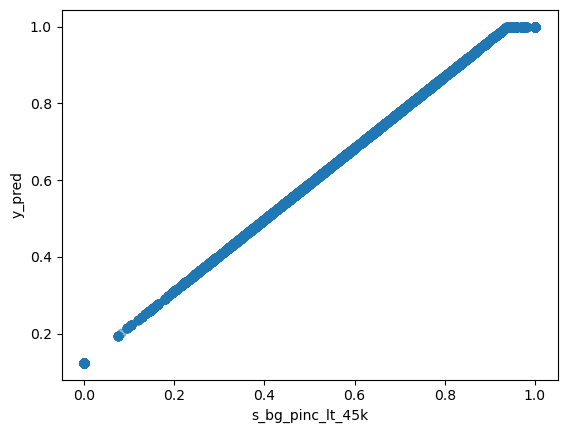

s_bg_pinc_lt_45k: 
 0.5446789080033402
y_pred: 
 0.6318152678099239


In [15]:
plt.scatter(merge5['s_bg_pinc_lt_45k'], merge5['y_pred'],  alpha=0.5)
plt.xlabel("s_bg_pinc_lt_45k")
plt.ylabel("y_pred")
plt.show()
print("s_bg_pinc_lt_45k: \n", merge5['s_bg_pinc_lt_45k'].mean())
print("y_pred: \n", merge5['y_pred'].mean())

### 12. Revision of joint density, call it s_joint_age_educ_inc_adj

In [16]:

# joint probability age*educ*income of target population (using y_pred)
merge5['s_joint_age_educ_inc_adj']=merge5['s_bg_age_gt18']*merge5['s_bg_educ_lt_bachelors']*merge5['y_pred']

# block-level estimate of target population
merge5['b_target_pop_adj']=merge5['b_population']*merge5['s_joint_age_educ_inc_adj']

# calculating density and distribution per sq miles
merge5['target_density_adj']=(merge5['b_target_pop_adj'] / whole_population_6_counties).fillna(0)
merge5['target_pop_per_sq_mile_adj']=merge5['b_target_pop_adj'] / (merge5['shape_area'] / whole_area_6_counties)



### 13. After the adjustment for correlation between income and education, joint density changes from 0.29 to 0.33

In [17]:

print("s_joint_age_educ_inc: \n", merge5['s_joint_age_educ_inc'].mean())
print("s_joint_age_educ_inc_adj: \n", merge5['s_joint_age_educ_inc_adj'].mean())
merge5.info()


s_joint_age_educ_inc: 
 0.29059760078943736
s_joint_age_educ_inc_adj: 
 0.3308518894458803
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37701 entries, 0 to 37700
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   b_gisjoin                   37701 non-null  object 
 1   state                       37701 non-null  object 
 2   county                      37701 non-null  object 
 3   b_population                37701 non-null  int64  
 4   fid                         37701 non-null  int32  
 5   shape_area                  37701 non-null  float32
 6   bg_gisjoin                  37701 non-null  object 
 7   bg_age_gt18                 37701 non-null  int64  
 8   s_bg_age_gt18               37701 non-null  float64
 9   bg_educ_lt_bachelors        37701 non-null  int64  
 10  bg_inc_lt_45000             37701 non-null  int64  
 11  s_bg_educ_lt_bachelors      37701 non-null  float64
 1

In [18]:
final_block_data=merge5[['fid', 'county' ,'bg_gisjoin' ,'b_gisjoin' ,'b_population', 'bg_age_gt18', 'bg_educ_lt_bachelors', 'bg_inc_lt_45000','s_bg_age_gt18', 's_bg_educ_lt_bachelors', 's_bg_inc_lt_45000', 'target_density', 's_joint_age_educ_inc_adj' ,'b_target_pop_adj', 'target_pop_per_sq_mile_adj', 'target_density_adj']]
final_block_data

,fid,county,bg_gisjoin,b_gisjoin,b_population,bg_age_gt18,bg_educ_lt_bachelors,bg_inc_lt_45000,s_bg_age_gt18,s_bg_educ_lt_bachelors,s_bg_inc_lt_45000,target_density,s_joint_age_educ_inc_adj,b_target_pop_adj,target_pop_per_sq_mile_adj,target_density_adj
0,0,Johnson County,G20009100500001,G20009100500001000,52,480,237,130,0.914286,0.697059,0.546218,0.000013,0.544359,28.306653,2634.734136,0.000014
1,1,Johnson County,G20009100500001,G20009100500001001,47,480,237,130,0.914286,0.697059,0.546218,0.000012,0.544359,25.584860,2462.999584,0.000013
2,2,Johnson County,G20009100500001,G20009100500001002,51,480,237,130,0.914286,0.697059,0.546218,0.000013,0.544359,27.762294,2725.120951,0.000014
3,3,Johnson County,G20009100500001,G20009100500001003,58,480,237,130,0.914286,0.697059,0.546218,0.000015,0.544359,31.572805,3020.188740,0.000016
4,4,Johnson County,G20009100500001,G20009100500001004,138,480,237,130,0.914286,0.697059,0.546218,0.000035,0.544359,75.121503,2611.948759,0.000038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37696,37696,Platte County,G29016509800001,G29016509800001121,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
37697,37697,Platte County,G29016509800001,G29016509800001122,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
37698,37698,Platte County,G29016509800001,G29016509800001123,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
37699,37699,Platte County,G29016509800001,G29016509800001124,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 14. Save Final Output File

In [19]:

csv_path_export = os.path.join(wd, 'intermediate_data', 'block_level_target_population_outofpython_20230427.csv')

final_block_data.to_csv(csv_path_export,index=False)

Note: Output csv file was joined and converted to GIS shapefile in ArcGIS.

### 15. Exploration of Final GIS data

In [20]:

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

In [21]:
shape_path_gdf_kc_6county = os.path.join(wd, 'gis_data', 'b_zip_kc_6_counties_union.shp')

gdf_kc_6county = gpd.read_file(shape_path_gdf_kc_6county)



In [23]:
final_csv = os.path.join(wd, 'intermediate_data', 'block_level_target_population_outofpython_20230427.csv') ## final csv file with all key features


In [24]:
block_final_csv = pd.read_csv(final_csv, low_memory=False)


In [25]:
gis_map_final=pd.merge(gdf_kc_6county, block_final_csv,on=['b_gisjoin' ])  # merge block map and output file.

In [26]:
gis_map_final.head()

,FID_zip_KC,GISJOIN,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,Shape_Leng,Shape_Area,b_gisjoin,state,...,bg_educ_lt_bachelors,bg_inc_lt_45000,s_bg_age_gt18,s_bg_educ_lt_bachelors,s_bg_inc_lt_45000,target_density,s_joint_age_educ_inc_adj,b_target_pop_adj,target_pop_per_sq_mile_adj,target_density_adj
0,0,G64012,64012,64012,B5,G6350,60516.96525,1.231256e+08,G29003700600011000,Missouri,...,384,114,0.897045,0.423374,0.231237,0.000000e+00,0.182441,0.000000,0.000000,0.000000e+00
1,0,G64012,64012,64012,B5,G6350,60516.96525,1.231256e+08,G29003700600011001,Missouri,...,384,114,0.897045,0.423374,0.231237,6.645384e-07,0.182441,1.641972,0.932577,8.359402e-07
2,0,G64012,64012,64012,B5,G6350,60516.96525,1.231256e+08,G29003700600011002,Missouri,...,384,114,0.897045,0.423374,0.231237,0.000000e+00,0.182441,0.000000,0.000000,0.000000e+00
3,0,G64012,64012,64012,B5,G6350,60516.96525,1.231256e+08,G29003700600011003,Missouri,...,384,114,0.897045,0.423374,0.231237,3.691880e-07,0.182441,0.912207,101.638757,4.644112e-07
4,0,G64012,64012,64012,B5,G6350,60516.96525,1.231256e+08,G29003700600011004,Missouri,...,384,114,0.897045,0.423374,0.231237,0.000000e+00,0.182441,0.000000,0.000000,0.000000e+00


### Comparison of key features and estimated share of eligible population

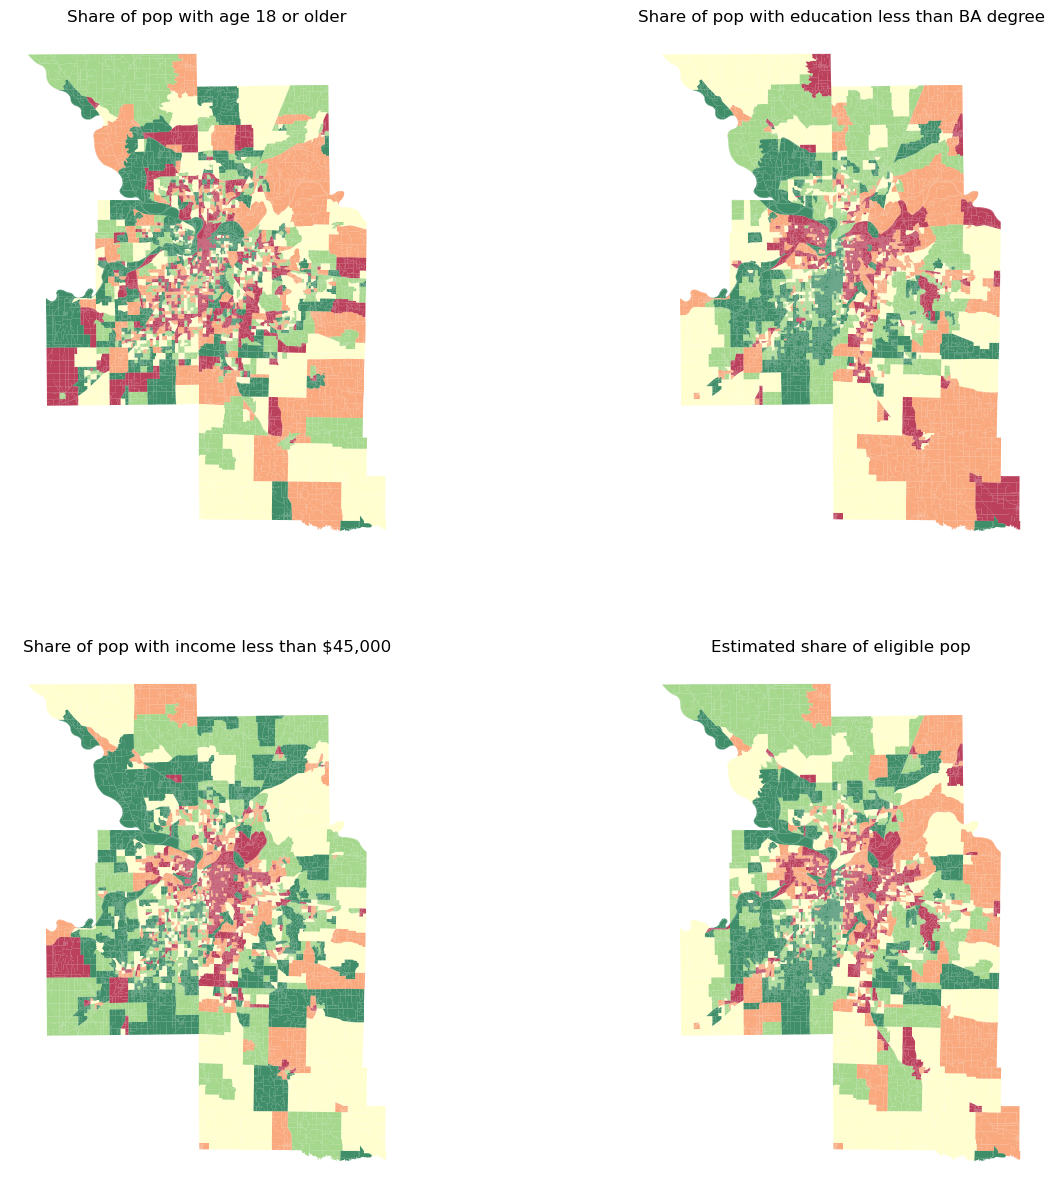

In [27]:
# create the 1x2 subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
gis_map_final.plot(ax=ax[0,0], # this assigns the map to the left subplot
         column='s_bg_age_gt18', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0,0].axis("off")
ax[0,0].set_title("Share of pop with age 18 or older")

# spatial lag map on the right
gis_map_final.plot(ax=ax[0,1], # this assigns the map to the right subplot
         column='s_bg_educ_lt_bachelors', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[0,1].axis("off")
ax[0,1].set_title("Share of pop with education less than BA degree")


# spatial lag map on the right
gis_map_final.plot(ax=ax[1,0], # this assigns the map to the right subplot
         column='s_bg_inc_lt_45000', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1,0].axis("off")
ax[1,0].set_title("Share of pop with income less than $45,000")

# spatial lag map on the right
gis_map_final.plot(ax=ax[1,1], # this assigns the map to the right subplot
         column='s_joint_age_educ_inc_adj', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1,1].axis("off")
ax[1,1].set_title("Estimated share of eligible pop")



plt.show()

### County-level map descriptive

In [28]:
sub=gis_map_final[['state','county_x']].drop_duplicates() ##keep the unique state-county information from the final map data.

In [29]:
sub=sub.rename(columns={'county_x':'county'}) ## rename for merge

In [30]:
sub.head()

,state,county
0,Missouri,Cass County
627,Missouri,Jackson County
1703,Missouri,Platte County
1756,Missouri,Clay County
26114,Kansas,Wyandotte County


In [31]:
sub.loc[sub['state']=='Missouri', 'STATEFP'] = '29' ## relabel for merging
sub.loc[sub['state']=='Kansas', 'STATEFP'] = '20'

In [32]:
sub.head()

,state,county,STATEFP
0,Missouri,Cass County,29
627,Missouri,Jackson County,29
1703,Missouri,Platte County,29
1756,Missouri,Clay County,29
26114,Kansas,Wyandotte County,20


In [33]:
shape_path_US_county_2021 = os.path.join(wd, 'gis_data', 'US_county_2021.shp')
gdf_US_county_2021 = gpd.read_file(shape_path_US_county_2021) 
gdf_US_county_2021=gdf_US_county_2021[(gdf_US_county_2021['STATEFP']=='29')|(gdf_US_county_2021['STATEFP']=='20')]

In [34]:
gdf_US_county_2021=gdf_US_county_2021.rename(columns={'NAMELSAD':'county'}) ## rename for merge

In [35]:
county_map=pd.merge(gdf_US_county_2021, sub,on=['county' ,'STATEFP'])  # merge block map and output file.

In [51]:
county=gis_map_final
county=county.rename(columns={'county_x':'county'}) ## rename for merge

In [52]:
d=county.groupby('county')['b_target_pop_adj'].sum()

In [53]:
d.head()

county
Cass County        37753.478625
Clay County        82900.503905
Jackson County    265647.489444
Johnson County    120798.459168
Platte County      27952.837919
Name: b_target_pop_adj, dtype: float64

In [54]:
gdf_US_county_2021=gdf_US_county_2021.rename(columns={'NAMELSAD':'county'})

In [55]:
county_map=pd.merge(county_map, d,on=['county' ])  # merge block map and output file.

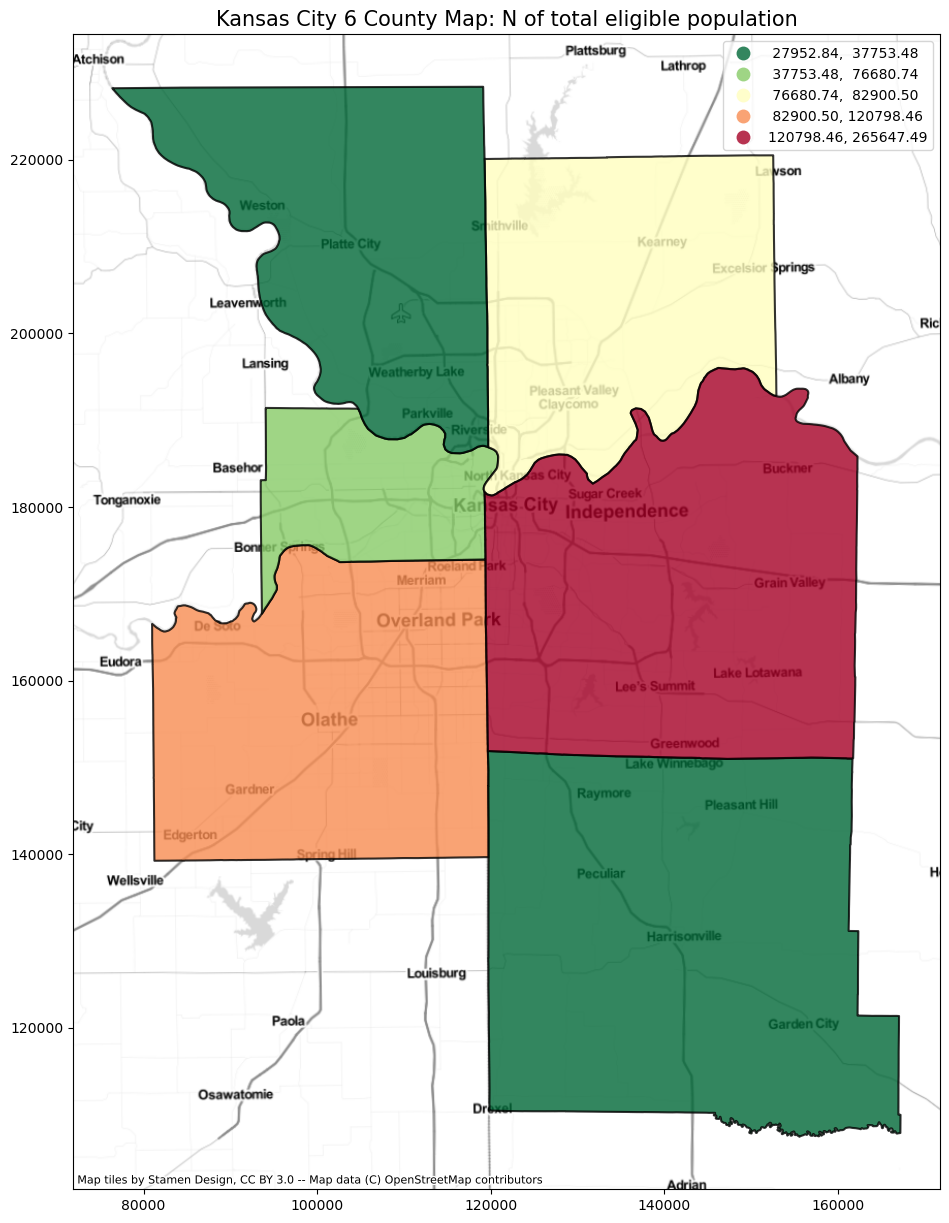

In [56]:
fig,ax = plt.subplots(figsize=(15,15))

county_map.plot(ax=ax,
        column='b_target_pop_adj', # this makes it a choropleth
        legend=True,
        alpha=0.8,
        edgecolor='black',
        lw=1.5,                
        cmap='RdYlGn_r', # a diverging color scheme
        scheme='quantiles') # how to break the data into bins
ax.set_title('Kansas City 6 County Map: N of total eligible population',fontsize=15)
# choose any of the supported maps from ctx.sources


ctx.add_basemap(ax, crs=county_map.crs.to_string(), zoom=10, source=ctx.providers.Stamen.TonerLite)


### Zipcode-level map descriptive

In [57]:
sub=gis_map_final[['state','ZCTA5CE20']].drop_duplicates() ##keep the unique state-county information from the final map data.

In [58]:
shape_path_zip_6county = os.path.join(wd, 'gis_data', 'zip_KC_6county.shp')
gdf_zip_6county = gpd.read_file(shape_path_zip_6county) 


In [59]:
zipcode_map=pd.merge(gdf_zip_6county, sub,on=['ZCTA5CE20'])  # merge block map and output file.

In [60]:
zip=gis_map_final
zip.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 37704 entries, 0 to 37703
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   FID_zip_KC                  37704 non-null  int64   
 1   GISJOIN                     37704 non-null  object  
 2   ZCTA5CE20                   37704 non-null  object  
 3   GEOID20                     37704 non-null  object  
 4   CLASSFP20                   37704 non-null  object  
 5   MTFCC20                     37704 non-null  object  
 6   Shape_Leng                  37704 non-null  float64 
 7   Shape_Area                  37704 non-null  float64 
 8   b_gisjoin                   37704 non-null  object  
 9   state                       37704 non-null  object  
 10  county_x                    37704 non-null  object  
 11  geometry                    37704 non-null  geometry
 12  fid                         37704 non-null  int64   
 13  county_y

In [61]:
zip=zip.groupby('ZCTA5CE20')['b_target_pop_adj'].sum()

In [62]:
zip.head()

ZCTA5CE20
64012    11165.568545
64014     8115.134751
64015    10287.711999
64016     1702.028217
64018      204.127198
Name: b_target_pop_adj, dtype: float64

In [63]:
zipcode_map=pd.merge(zipcode_map, zip,on=['ZCTA5CE20' ])  # merge block map and output file.

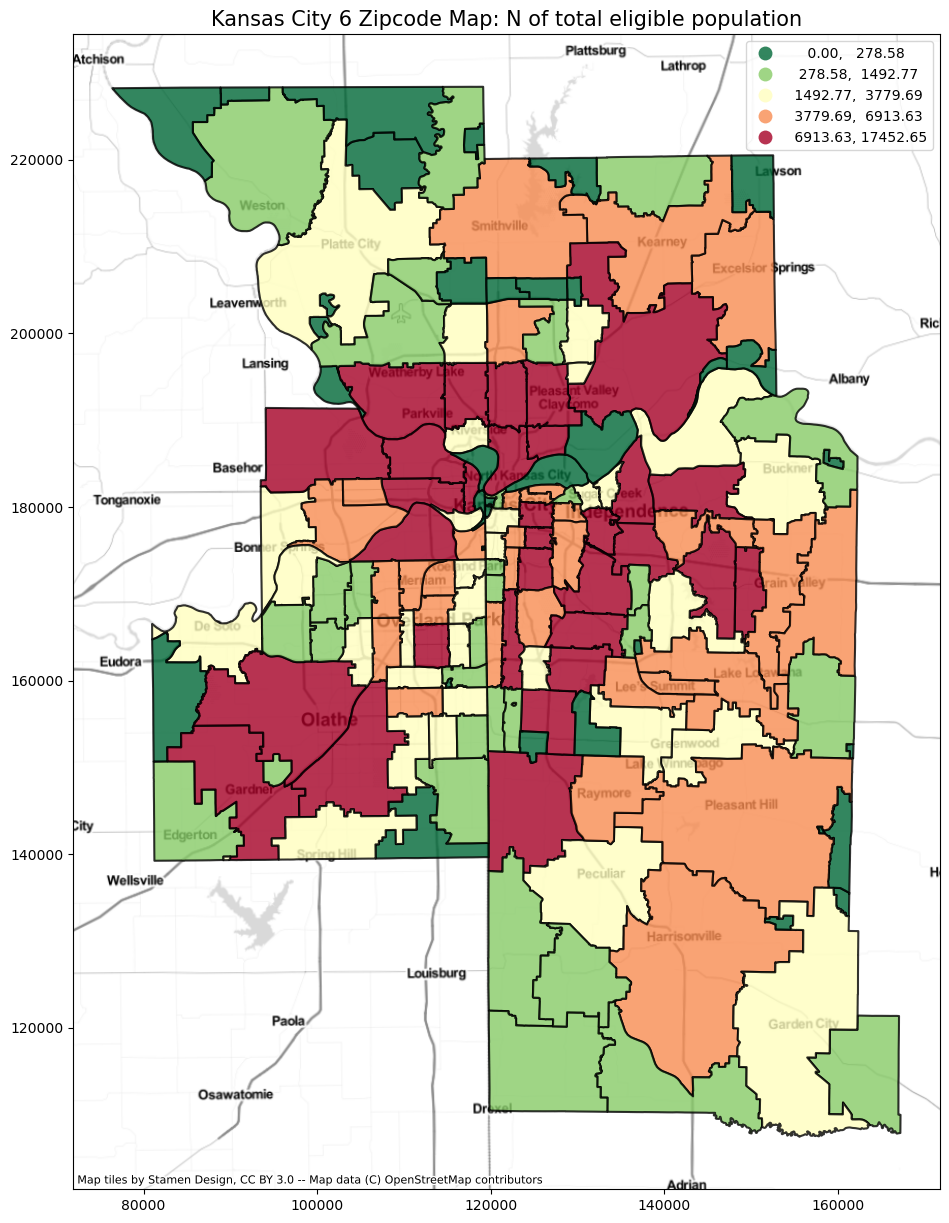

In [64]:
fig,ax = plt.subplots(figsize=(15,15))

zipcode_map.plot(ax=ax,
        column='b_target_pop_adj', # this makes it a choropleth
        legend=True,
        edgecolor='black',
        lw=1.5,
        alpha=0.8,
        cmap='RdYlGn_r', # a diverging color scheme
        scheme='quantiles') # how to break the data into bins
ax.set_title('Kansas City 6 Zipcode Map: N of total eligible population',fontsize=15)
# choose any of the supported maps from ctx.sources


ctx.add_basemap(ax, crs=zipcode_map.crs.to_string(), zoom=10, source=ctx.providers.Stamen.TonerLite)


### Interactive map

In [148]:
# set the mapbox access token
token = 'pk.eyJ1Ijoid29ubGVlIiwiYSI6ImNqYjY0bHZlczBvMnAzMm16OTlyYWFzYnYifQ.yaLx92dXVMk1NKp5Fp7HUg'
px.set_mapbox_access_token(token)

In [150]:
# subset diamond, project to WGS84, and get its centroid
gis_map_final_cent = gis_map_final.to_crs('epsg:4326')

# what's the centroid?
minx, miny, maxx, maxy = gis_map_final_cent.geometry.total_bounds
center_lat_cent  = (maxy-miny)/2+miny
center_lon_cent = (maxx-minx)/2+minx

In [ ]:
median = gis_map_final.target_pop_per_sq_mile_adj.median()

fig = px.choropleth_mapbox(gis_map_final_cent, 
                     geojson=gis_map_final_cent.geometry, # the geometry column
                     locations=gis_map_final_cent.index, # the index
                     mapbox_style="satellite-streets",
                     zoom=9, 
                     color='target_pop_per_sq_mile_adj',
                     color_continuous_scale='RdYlGn_r',
                     color_continuous_midpoint =median, # put the median as the midpoint
                     range_color =(0,median*2),
                     hover_data=['target_pop_per_sq_mile_adj','s_joint_age_educ_inc_adj','b_population','ZCTA5CE20', 'county_x','state'],
                     center = {"lat": center_lat_cent, "lon": center_lon_cent},
                     opacity=0.8,
                     width=1000,
                     height=800,
                     labels={
                             'target_pop_per_sq_mile_adj':'N eligible pop/sq mile',
                             's_joint_age_educ_inc_adj':'Share of eligible pop',
                             'b_population': 'N total population',
                             'ZCTA5CE20':'Zipcode',
                             'county_x':'County',
                             'state':'State',
                      })
fig.update_traces(marker_line_width=0.1, marker_line_color='white')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})


## Spatial Autocorrelation

In [65]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import libpysal as lp

#### Contiguity weights need to be assigned for spatial autocorrelation. Applying the Queen's methodology fits this analysis best since neighboring blocks are similar. For example, the rock methodology would only consider neighboring blocks at the sides, whereas the Queen's approach also considers those at the vertices. Also, row standardization is applied.

In [67]:
gis_map_final_imp=gis_map_final[['b_target_pop_adj','geometry']]
wq=lp.weights.Queen.from_dataframe(gis_map_final_imp)
wq.transform='r'

In [68]:
gis_map_final_imp.head(2)

,b_target_pop_adj,geometry
0,0.000000,"POLYGON ((123581.950 151684.571, 123461.917 15..."
1,1.641972,"POLYGON ((123389.753 151707.336, 123389.559 15..."


### Create the lagged spatial weights for the target population

In [69]:
y=gis_map_final_imp['b_target_pop_adj']
ylag=lp.weights.lag_spatial(wq,y)
# ylag

### Generate the Moran's Scatterplot on the block level target population (adj.) The plot does not show a strong presence of spatial autocorrelation--suggested by a weak presence of points along the red line.

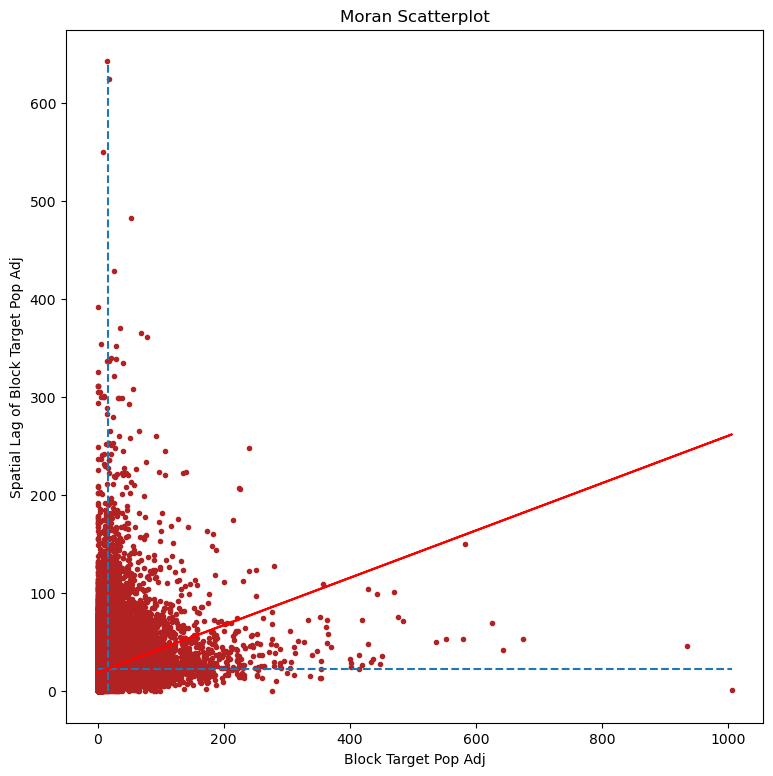

In [70]:
# Spatial Autocorrelation - Moran's Scatterplot on the block level target population (adj.)
lag_target_pop=lp.weights.lag_spatial(wq,gis_map_final_imp['b_target_pop_adj'])
target_pop=gis_map_final_imp['b_target_pop_adj']
b,a=np.polyfit(target_pop, lag_target_pop,1)
f,ax=plt.subplots(1,figsize=(9,9))

plt.plot(target_pop,lag_target_pop,'.',color='firebrick')

plt.vlines(target_pop.mean(), lag_target_pop.min(), lag_target_pop.max(), linestyle='--')
plt.hlines(lag_target_pop.mean(), target_pop.min(), target_pop.max(), linestyle='--')

plt.plot(target_pop, a + b*target_pop, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Block Target Pop Adj')
plt.xlabel('Block Target Pop Adj')

plt.show()

### Assign the four quadrants from Moran's plot. Each quadrant is tested for significance in the data. 
* HH - high high (cluster type: hotspot)
* LL - low low (cluster type: lowspot)
* LH - low high (cluster type: doughnut, i.e. high values surrounded by low values)
* HL - high low (cluster type: diamond, i.e. low values surrounded by high values)

In [71]:
li=esda.moran.Moran_Local(y,wq)
# (li.p_sim<0.05).sum()

sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond

spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

### Summary: 
* In conjunction with the earlier Moran's scatterplot and the below plot, there appears to be some spatial autocorrelation for our target areas (hot spot locations) at the local level. 
* However, overall spacially, there isn't a significant spatial autocorrelation that points to one region (or higher) of KC counties to be heavily hot spot activity. 
* This may suggest strategic target zones to direct marketing resources based on spatial analysis.

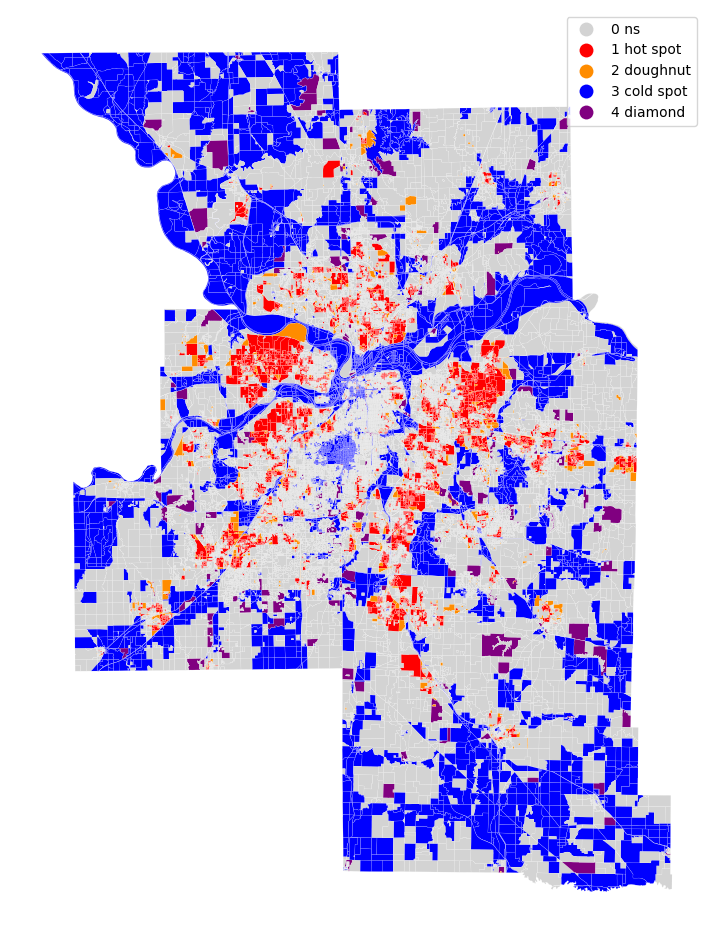

In [72]:
# Plot Moran's 4 quadrant clusters (statistically significant levels)
from matplotlib import colors
hmap = colors.ListedColormap(['lightgrey', 'red', 'darkorange', 'blue', 'purple'])
f, ax = plt.subplots(1, figsize=(12, 12))
gis_map_final.assign(cl=labels).plot(column='cl', categorical=True, 
        k=2, cmap=hmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()